In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [34]:
testSTART = '2021-12-31'

In [49]:
import datetime

# принимает строку, приращивает дату, возвращает строку
# по умолчанию возвращает следующий день
def NextDay(date_str, delta=1):
    date_time = datetime.datetime.strptime(date_str, "%Y-%m-%d").date() + datetime.timedelta(days=delta)
    return date_time.strftime("%Y-%m-%d")

In [2]:
df = pd.read_csv('../data/mvp_data.csv', parse_dates=True, index_col=0)
tickers = ['EUR', 'GOLD', 'Bitcoin', 'Apple', 'Exxon', 'VISA', 'Oil']
df.columns = tickers
# заполним пропуски последними известными значениями, так как пропуски чаще всего - это праздничные периоды
# перейдем на недельный интервал и средним значениям на них
df_w = df.fillna(method='ffill').resample('W').ffill()
df_w_pct = df_w.pct_change().iloc[1:] # отнсительные изменения к предыдущей неделе
df_w_log = np.log(df_w/df_w.shift(1)).iloc[1:] # переходим к логдоходности
df_w_log.head()

,EUR,GOLD,Bitcoin,Apple,Exxon,VISA,Oil
Date,,,,,,,
2020-01-12,-0.005415,0.005343,0.106043,0.042457,-0.017065,0.021755,-0.065713
2020-01-19,0.002559,0.000834,0.089262,0.026708,-0.008424,0.054873,-0.008505
2020-01-26,-0.007602,0.007860,-0.055683,-0.001319,-0.033218,0.001465,-0.077214
2020-02-02,-0.002363,0.007483,0.101807,-0.028035,-0.065424,-0.029856,-0.049750
2020-02-09,-0.004193,-0.009075,0.046535,0.035795,-0.010519,0.018770,-0.024344


In [3]:
train_df = df_w_log[:'2021-12-31'] # TRAIN 2020-2021
test_df = df_w_log['2022-01-01':] # TEST 2022

In [162]:
assetsNum = len(df.columns)
period_ret = 52 # для перехода от недельной к годовой доходности
iterNum = 10000

all_portf = np.zeros((iterNum, assetsNum)) # все портфели
ret_arr = np.zeros(iterNum) # доходность
vol_arr = np.zeros(iterNum) # волатильность для оценки риска
sharpe_arr = np.zeros(iterNum)

for x in range(iterNum):
    portf = np.array(np.random.random(assetsNum))
    portf = portf/np.sum(portf)
    
    all_portf[x,:] = portf
    
    ret_arr[x] = np.sum((train_df.mean()*portf*period_ret))
    
    vol_arr[x] = np.sqrt(np.dot(portf.T, np.dot(train_df.cov()*period_ret, portf)))
    
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [163]:
max_sharpe_portf = sharpe_arr.argmax()
max_sharpe_ret = ret_arr[sharpe_arr.argmax()]
max_sharpe_vol = vol_arr[sharpe_arr.argmax()]

print(sharpe_arr.max())
print(max_sharpe_portf)
print(all_portf[max_sharpe_portf, :])

1.5826315113863054
4106
[0.2476684  0.09384766 0.19071021 0.37901777 0.00669074 0.08140686
 0.00065835]


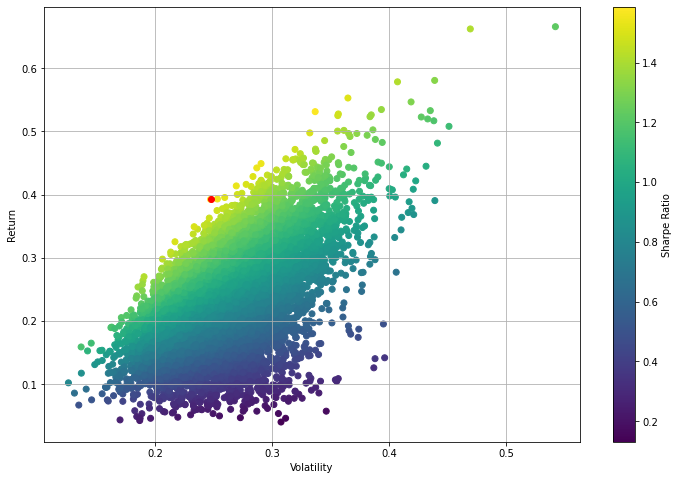

In [6]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sharpe_vol, max_sharpe_ret, c='red')
plt.grid()
plt.show()

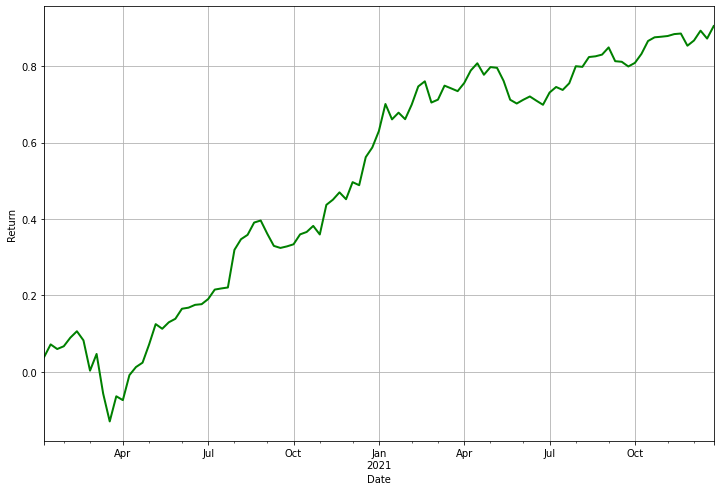

In [164]:
plt.figure(figsize=(12,8))
plt.ylabel('Return')
np.matmul(df_w_pct[:'2021-12-31'], all_portf[max_sharpe_portf, :]).cumsum().plot(color='green', linewidth=2)
plt.grid()
plt.show()

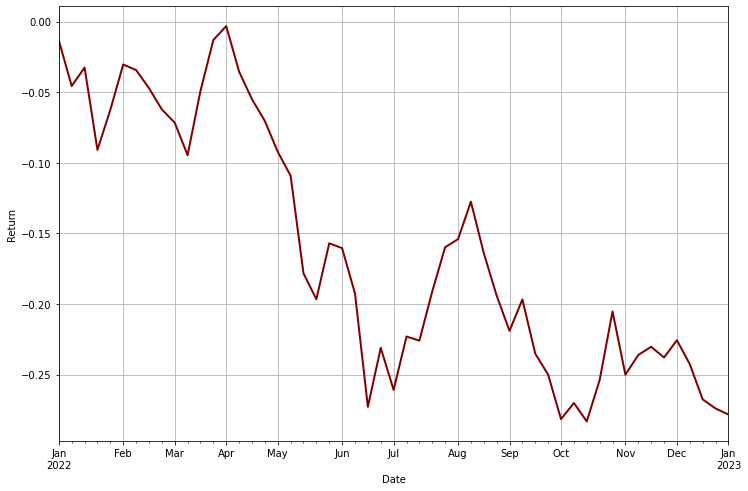

In [165]:
# бэктест
plt.figure(figsize=(12,8))
plt.ylabel('Return')
np.matmul(df_w_pct['2022-01-01':], all_portf[max_sharpe_portf, :]).cumsum().plot(color='maroon', linewidth=2)
plt.grid()
plt.show()

### Поиск оптимального портфеля с помощью МНК

In [7]:
# возвращает прибыль, волатильность и коэффициент Шарпа для любого портфеля
def get_params(portf):
    portf = np.array(portf)
    ret = np.sum(df_w_log.mean() * portf) * period_ret
    vol = np.sqrt(np.dot(portf.T, np.dot(df_w_log.cov()*period_ret, portf)))
    shrp = ret/vol
    return np.array([ret, vol, shrp])

# вовзращает отрицательный кэф. Шарпа, чтобы решать задачу минимизации
def neg_sharpe(portf):
    return get_params(portf)[2] * -1

# проверка на валидность: возвращает 0, если сумма равна 1
def check_valid(portf):
    return np.sum(portf) - 1

In [8]:
cons = ({'type': 'eq', 'fun': check_valid})
bounds = tuple([(0, 1) for _ in range(assetsNum)])
init_portf = [1/assetsNum for _ in range(assetsNum)]


In [9]:
# поиск оптимального портфеля с помощью МНК
from scipy.optimize import minimize
res = minimize(neg_sharpe, init_portf, method='SLSQP', bounds=bounds, constraints=cons)
print(res)

     fun: -0.7263818464707447
     jac: array([ 1.54389791e-01,  3.99500132e-05, -6.08116388e-05,  3.66866589e-05,
       -7.18981028e-05,  4.29453090e-01,  4.52182531e-01])
 message: 'Optimization terminated successfully'
    nfev: 57
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.        , 0.1977801 , 0.07401672, 0.45088955, 0.27731363,
       0.        , 0.        ])


In [10]:
get_params(res.x)

array([0.17551164, 0.24162448, 0.72638185])

## Визуализация границ

In [12]:
def minimize_vol(portf):
    return get_params(portf)[1]

In [13]:
frontier_x = []
frontier_y = np.linspace(0, 0.6, 200)

for y in frontier_y:
    cons = ({'type':'eq', 'fun': check_valid},
            {'type':'eq', 'fun': lambda w: get_params(w)[0] - y})
    
    result = minimize(minimize_vol, init_portf, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

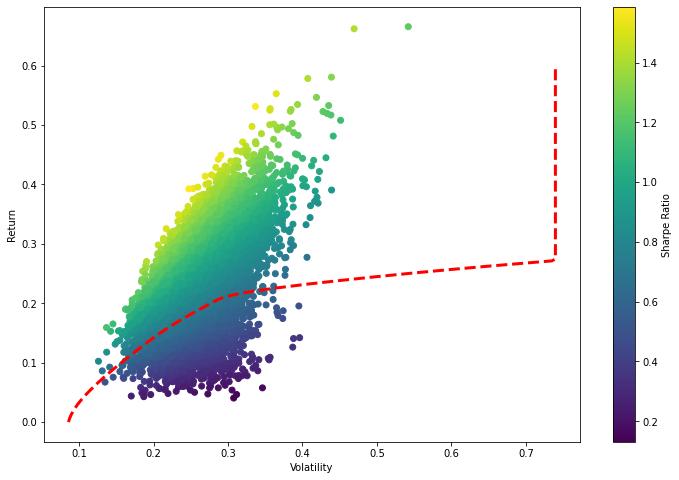

In [22]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x, frontier_y, 'r--', linewidth=3)
plt.show()

### Какая-то бяка... тут надо поработать еще с визуализацией границы, само облако портфелей рисуется нормально

In [32]:
# переделать через vol_arr, ret_arr, bounds_ef = np.arange(0, 1, 0.1), 
# = sharpe_arr.argmax() - для каждого отдельного участка
# = ret_arr[sharpe_arr.argmax()]
# = vol_arr[sharpe_arr.argmax()]
# frontier_x
# frontier_y

## Динамика по портфелю + тестирование

In [15]:
train_din = np.matmul(df_w_pct[:'2021-12-31'], res.x).cumsum() # TRAIN 2020-2021
test_din = np.matmul(df_w_pct['2022-01-01':], res.x).cumsum() # TEST 2022

<AxesSubplot:xlabel='Date'>

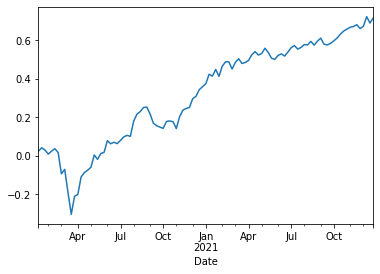

In [16]:
train_din.plot()

<AxesSubplot:xlabel='Date'>

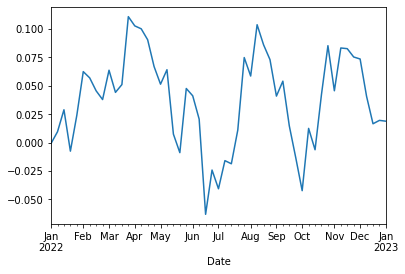

In [17]:
test_din.plot()

### Выглядит не очень. Можно применить ребалансировку раз в период

## Ребалансировка

In [166]:
# сколько дней бэктеста всего
backPeriodAll = (df_w_log.index[-1] - df_w_log[testSTART:].index[0]).days

# раз в сколько дней делать ребалансировку
reFreq = 90

periods = backPeriodAll // reFreq

reWindow = 180 # окно скольжения для ребалансировки

# формируем все даты ребалансировки
reDates = []

for period in range(periods):
    reDates.append(NextDay(testSTART, reFreq*period))

reDates

['2021-12-31', '2022-03-31', '2022-06-29', '2022-09-27']

In [192]:
tmp = {}

for i in range(4):
    tmp[i] = i**2

print(tmp)

{0: 0, 1: 1, 2: 4, 3: 9}


In [199]:
period_ret = 52 # для перехода от недельной к годовой доходности
iterNum = 5000
assetsNum = len(df.columns)
rePortfs = {}

for d in range(len(reDates)):
    retrain_df = df_w_log[NextDay(reDates[d], -reWindow):reDates[d]] # взятия окна обучения для ребалансировки

    all_portf = np.zeros((iterNum, assetsNum)) # все портфели
    ret_arr = np.zeros(iterNum) # доходность
    vol_arr = np.zeros(iterNum) # волатильность для оценки риска
    sharpe_arr = np.zeros(iterNum)

    for x in range(iterNum):
        portf = np.array(np.random.random(assetsNum))
        portf = portf/np.sum(portf)
        
        all_portf[x,:] = portf
        
        ret_arr[x] = np.sum((retrain_df.mean()*portf*period_ret))
        
        vol_arr[x] = np.sqrt(np.dot(portf.T, np.dot(retrain_df.cov()*period_ret, portf)))
        
        sharpe_arr[x] = ret_arr[x]/vol_arr[x]
    
    max_sharpe_portf = sharpe_arr.argmax()
    max_sharpe_ret = ret_arr[sharpe_arr.argmax()]
    max_sharpe_vol = vol_arr[sharpe_arr.argmax()]

    # rePortfs.append(all_portf[max_sharpe_portf, :])
    rePortfs[reDates[d]] = list(all_portf[max_sharpe_portf, :])

    print(d, '=============================')
    print(sharpe_arr.max())
    print(max_sharpe_portf)
    print(all_portf[max_sharpe_portf, :])

0 =============================
2.630658182907129
3035
[0.06169107 0.09514132 0.22523441 0.44541762 0.00331618 0.11577741
 0.05342199]
1 =============================
3.1711229392958726
2806
[0.1361864  0.32493375 0.01157513 0.18756148 0.3109387  0.02175569
 0.00704885]
2 =============================
1.7511249059259535
3377
[0.05991675 0.07613254 0.002676   0.01033158 0.47449649 0.19322409
 0.18322255]
3 =============================
-0.8410644129077736
2970
[0.20249816 0.01763206 0.01634185 0.23967036 0.38938293 0.10455295
 0.02992168]


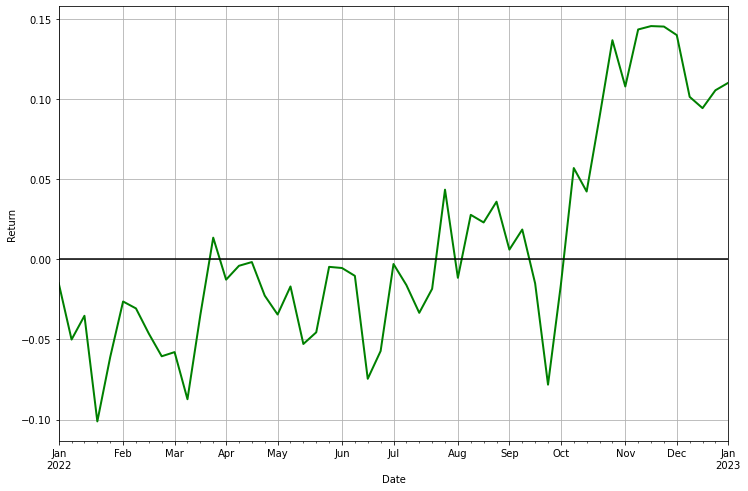

In [203]:
# визуалзиация на процентной доходности
part_retest_df = df_w_pct[NextDay(reDates[0]):reDates[1]]

for d in range(len(reDates)):
        try:
            retest_df = df_w_pct[NextDay(reDates[d]):reDates[d+1]]
        except:
            retest_df = df_w_pct[NextDay(reDates[d]):]
        if d == 0:
            retest_din = np.matmul(retest_df, rePortfs[reDates[d]]).cumsum()
        else:        
            # re_train_din = np.matmul(df_w_pct[:'2021-12-31'], res.x).cumsum() # TRAIN 2020-2021
            retest_din = pd.concat([retest_din, np.matmul(retest_df, rePortfs[reDates[d]]).cumsum()])

plt.figure(figsize=(12,8))
retest_din.plot(color='green', linewidth=2)
plt.ylabel('Return')
plt.grid()
plt.axhline(y=0, color='black')
plt.show()

In [231]:
# Доходность портфеля за период
print('Доходность портфеля за год {:.2%}'.format(retest_din[-1]))
# Шарп (возможно, слишком упрощенный расчет)
print('Коэффициент Шарпа {:.2f}'.format(retest_din[-1] / retest_din.std()))

Доходность портфеля за год 11.03%
Коэффициент Шарпа 1.65


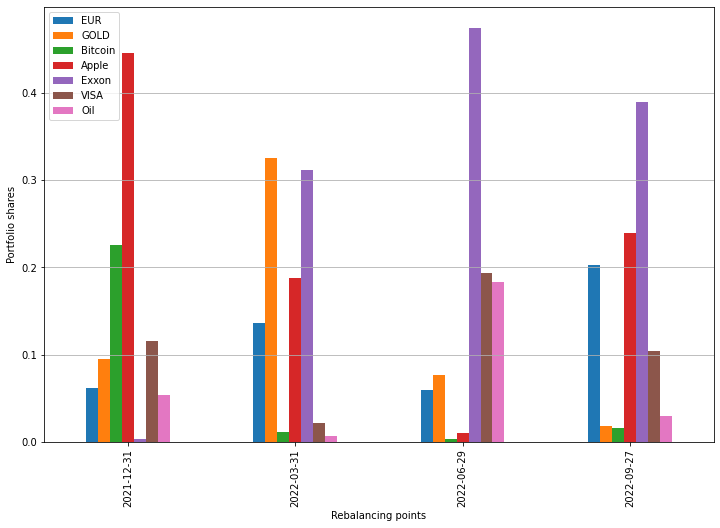

In [229]:
pd.DataFrame(rePortfs).T.plot(kind='bar', figsize=(12,8))
plt.legend(tickers)
plt.grid(axis='y')
plt.ylabel('Portfolio shares')
plt.xlabel('Rebalancing points')
plt.show()